### Sandbox

In [5]:
# loading files as binary without parsing
with open("ImageSources\\png\\boba_fett.png", "rb") as file:
    binary = file.read()
    print(binary[:20])
    print(len(binary))

print("done")

import base64
def b64_utf8_encode(string):
    string_b64 = base64.b64encode(string.encode("utf-8"))
    encodedStr = str(string_b64, "utf-8")

    print(encodedStr)
    return string_b64

def b64_utf8_decode(string):
    decodedBytes = base64.b64decode(string)
    decodedStr = str(decodedBytes, "utf-8")

    print(decodedStr)
    return decodedBytes

secret = b64_utf8_encode("It's about drive, it's about power")
print(secret)
print(b64_utf8_decode(secret))

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03-'
1336931
done
SXQncyBhYm91dCBkcml2ZSwgaXQncyBhYm91dCBwb3dlcg==
b'SXQncyBhYm91dCBkcml2ZSwgaXQncyBhYm91dCBwb3dlcg=='
It's about drive, it's about power
b"It's about drive, it's about power"


### create default and user settings

In [6]:
import configparser
config = configparser.ConfigParser()
config['DEFAULT']['optcut']         = str(True)
config['DEFAULT']['colorspace']     = str(0)
config['DEFAULT']['max_cut']        = str(0.4)
config['DEFAULT']['max_row']        = str(900)
config['DEFAULT']['max_col']        = str(1600)
config['DEFAULT']['resize_enable']  = str(True)
config['DEFAULT']['image_type']     = str(0)
config['DEFAULT']['recursive_count']= str(0)
config['DEFAULT']['static_gain']    = str(0)

with open('settings.ini', 'w') as configfile:    # save
    config.write(configfile)
    print("default settings written")


config['USER'] = {}
config['USER']['optcut']            = str(True)
config['USER']['colorspace']        = str(0)
config['USER']['max_cut']           = str(0.4)
config['USER']['max_row']           = str(900)
config['USER']['max_col']           = str(1600)
config['USER']['resize_enable']     = str(True)
config['USER']['image_type']        = str(0)
config['USER']['recursive_count']   = str(0)
config['USER']['static_gain']       = str(0)
with open('settings.ini', 'w') as configfile:    # save
    config.write(configfile)
print("user settings written")



config.read('settings.ini')
print(config.getboolean('DEFAULT', 'optcut'))
print(type(config.getboolean('DEFAULT', 'optcut')))

print(config.getint('DEFAULT', 'colorspace'))
print(type(config.getint('DEFAULT', 'colorspace')))

print(config.getfloat('DEFAULT', 'max_cut'))
print(type(config.getfloat('DEFAULT', 'max_cut')))

default settings written
user settings written
True
<class 'bool'>
0
<class 'int'>
0.4
<class 'float'>


<br>
<br>

# Steganography in the frequency domain via the FFT
----

### Load settings

In [11]:
#colorspace_dict = { 0:"RGB", 1: "YCbCr"}
from enum import Enum

# Colorspaces available for embedding/decoding
class Colorspace(Enum):
    RGB     = 0
    YCbCr   = 1

# Image file formats when saving steganogram
class ImageType(Enum):
    png     = 0
    tif     = 1
    webp    = 2

# currently unused
class MessageType(Enum):
    utf8    = 0
    txt     = 1
    pdf     = 2
    gif     = 3

HEADER_LEN = 97

In [12]:
import configparser
config = configparser.ConfigParser()

# load settings
config.read('settings.ini')
optcut          = config.getboolean('USER', 'optcut')
colorspace      = config.getint('USER', 'colorspace')
max_cut         = config.getfloat('USER', 'max_cut')
max_row         = config.getint('USER', 'max_row')
max_col         = config.getint('USER', 'max_col')
resize_enable   = config.getboolean('USER', 'resize_enable')
image_type      = config.getint('USER', 'image_type')
recursive_count = config.getint('USER', 'recursive_count')
static_gain     = config.getint('USER', 'static_gain')

print([item for item in config['USER'].items()])

[('optcut', 'True'), ('colorspace', '0'), ('max_cut', '0.4'), ('max_row', '900'), ('max_col', '1600'), ('resize_enable', 'True'), ('image_type', '0'), ('recursive_count', '0'), ('static_gain', '0')]


### Functions for encoding and decoding

In [13]:
import copy

# create a namespace for generating the binary Message. also referred to as "encoding"
def generateMessage(text: str, gain: int or list, colorspace: int) -> tuple:

    # converts a string to its binary representation
    def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
        bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
        return bits.zfill(8 * ((len(bits) + 7) // 8))

    # splits a list into 2/3 pieces, according to the colorspace chosen previously
    def splitList(lst: list) -> list:
        split_lst = []
        if Colorspace(colorspace) == Colorspace.RGB:
            # divide into 3 pieces
            cut_points = findCutPoints(len(lst), 3)
            print("cut_points: ", cut_points)
            split_lst.append(lst[:cut_points[0]])
            split_lst.append(lst[cut_points[0]:cut_points[1]])
            split_lst.append(lst[cut_points[1]:])
        else:
            # divide into 2 pieces
            cut_points = findCutPoints(len(lst), 2)
            split_lst.append(lst[:cut_points[0]])
            split_lst.append(lst[cut_points[0]:])
        return split_lst

    # a function for finding the optimal point for splitting a list into sublists of equal length
    def findCutPoints(n,k) -> list:
        q,r = divmod(n-k+1,k)
        bigSteps = list(range(q+1, r*(q+2), q+2))
        littleSteps = list(range(r*(q+2) + q, n, q + 1))
        return bigSteps + littleSteps

    # returns a list with the lengths of the sublists in binary representation.
    def getLengthBinary(split_message: list) -> list:
        message_len = []

        # append length of 0 if first channel is unused (-> YCbCr)
        if len(split_message) == 2:
            message_len.append(0)

        for message in split_message:
            message_len.append(len(message))
        # print("message_len", message_len)

        len_binary_gained = []
        for length in message_len:
            # get length of bitstream in binary representation (overflow error if too large)
            len_binary = bin(length)[2:]

            # check if length is under 32 bits
            while len(len_binary) < 32:
                len_binary = '0' + len_binary
            # create int array and multiply with gain
            len_binary_gained.append([int(j) for j in len_binary])
        
        return len_binary_gained
    
    def colorspaceBinary(colorspace: Colorspace) -> Colorspace:
        if (colorspace != Colorspace.RGB) and (colorspace != Colorspace.YCbCr):
            raise ValueError("This colorspace is unknown!")
        return colorspace.value

    # assembles parts of the header previously transformed to binary form (integer list/array)
    def header(len_binary: list, colorspace_bin: int) -> list:
        head = []

        # flatten list and append to a single header list
        head.append(colorspace_bin)
        for len in len_binary:
            for l in len:
                head.append(l)
        # return [gain*h for h in head]
        return head

    # generate header
    binary_text = text_to_bits(text)
    split_bin_text = splitList(binary_text)
    len_binary = getLengthBinary(split_bin_text)
    colorspace_bin = colorspaceBinary(colorspace)
    head = header(len_binary, colorspace_bin)

    # print("split binary text: ", split_bin_text)
    print("binary message length (encoding):", [len(sbt) for sbt in split_bin_text])
    # print("colorspace: ",colorspace_bin)
    # print("len_binary after gain: ", len_binary)
    # print("head", head)

    # generate message and append header to last channel
    body = []
    for bin_text in split_bin_text:
        body.append([int(s) for s in bin_text])
    full_bin_message = body
    full_bin_message[-1] = [h for h in head] + body[-1]
    
    # print("full_bin_message: ", full_bin_message)

    # apply gain
    if type(gain) == int:
        full_bin_message_gain = [[i*gain for i in fbm] for fbm in full_bin_message]
    elif type(gain) == list:
        full_bin_message_gain = [[i*gain[ix] for i in fbm] for ix, fbm in enumerate(full_bin_message)]
    
    # print("gain: ", gain)
    # print("full_bin_message_gain: ", full_bin_message_gain)

    return full_bin_message_gain, full_bin_message


# create a namespace for parsing the binary Message. also referred to as "decoding"
def parseMessage(message: list, threshold: list) -> list:

    # convert inverse transformed message to parseable binary message
    def message2bin(message, threshold: int):
        digital = copy.deepcopy(message)
        for ix, m in enumerate(message):
            for iix in range(len(m)):
                if message[ix][iix] > threshold[ix]:
                    digital[ix][iix] = 1
                else:
                    digital[ix][iix] = 0
        return digital
    

    # parses the header from the binary message and returns its elements
    def parseHeader(message_bin: list):
        # isolate header channel
        header_channel = message_bin[-1]
        header_body = header_channel[:1+3*32]
        # print("header body: ", header_body)

        colorspace = header_body[0]

        message_len_bin = []
        message_len_bin.append(header_body[1:HEADER_LEN-32*2])
        message_len_bin.append(header_body[HEADER_LEN-32*2:HEADER_LEN-32])
        message_len_bin.append(header_body[HEADER_LEN-32:HEADER_LEN])

        # print("parsed message length binary: ", message_len_bin)

        # convert each element to string to concatenate the array
        parsed_message_len = []
        for channel in message_len_bin:
            message_len = ""
            for bit in channel:
                message_len = message_len + str(bit)
            # convert string to int (base 2) and calculate its decimal representation
            tmp = int(message_len, 2)
            # skip appending if length is 0
            if tmp == 0:
                continue
            parsed_message_len.append(tmp)

        # print("parsed message length: ", parsed_message_len)

        return Colorspace(colorspace), parsed_message_len



    def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
        n = int(bits,2)
        return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'


    def parseContent(message_binary: list, parsed_message_len: list) -> str:

        string_bits_concat = []
        for ix, mes_bin in enumerate(message_binary):
            string_bits_concat.append([str(i) for i in mes_bin[(ix==(len(parsed_message_len)-1))*HEADER_LEN:(ix==(len(parsed_message_len)-1))*HEADER_LEN+parsed_message_len[ix]]])
             
        # print("string bits concat: ", string_bits_concat)
        string_concat = ""
        string_decoded = ""
        # concatenate each element to one string
        for channel in string_bits_concat:
            for string in channel:
                string_concat += string
        string_decoded += text_from_bits(string_concat)

        return string_decoded


    message_binary = message2bin(message, threshold)


    # print(message_binary)
    parsed_colorspace, parsed_message_len = parseHeader(message_binary)
    print("parsed message length: ", parsed_message_len)
    # print("parsed colorspace: ", parsed_colorspace)

    message_binary_header = []
    for ix, mb in enumerate(message_binary):
        # increase the length at the last channel by the length of the header
        message_binary_header.append(mb[:parsed_message_len[ix]+HEADER_LEN*(ix==(len(message_binary)-1))].tolist())
        
    string_decoded = parseContent(message_binary, parsed_message_len)
    return string_decoded, message_binary_header


# normalize a channel by its max and min values
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

### Import modules and load image

image size:  (675, 900)


Text(0.5, 1.0, '2')

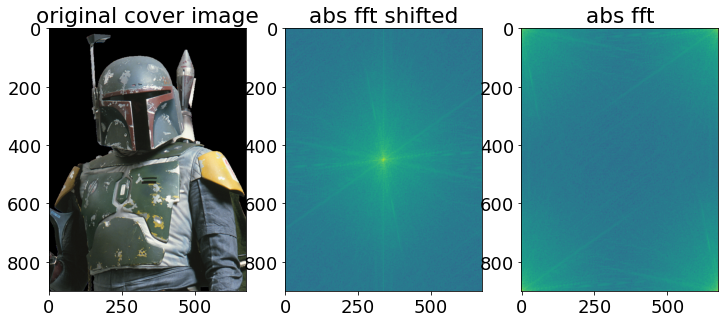

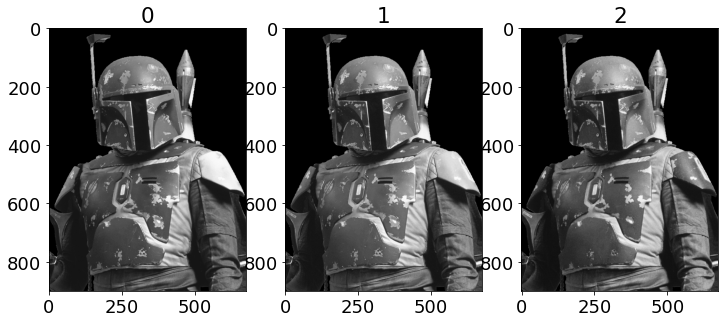

In [14]:
from PIL import Image
import numpy as np
import configparser
import matplotlib.pyplot as plt
%matplotlib inline

# some settings for inline plots
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams.update({'font.size':18})

# specifying cover image path
cover_img_path = "ImageSources\\png\\boba_fett.png"
# cover_img_path = "ImageSources\\jfif\\the_rock.jfif"
# cover_img_path = "C:\\Users\\maxik\\Documents\\Semester_6\\Projektarbeit\\github_repo\\Steganography\\ImageSources\\jpg\\iron_patriot.jpg"
# cover_img_path = "C:\\Users\\maxik\\Documents\\Semester_6\\Projektarbeit\\github_repo\\Steganography\\ImageSources\\jfif\\obi-wan_kenobi.jfif"


# resize image if too large (>1600/900) and return Pillow Image object (not stored yet)
def resize(cover_img_path: str) -> Image:
    image = Image.open(cover_img_path)
    # get real size
    cols, rows = image.size

    # handle exception first
    if (cols < max_col) and (rows < max_row):
        return image

    # calculate aspect ratio
    ratio = cols/rows

    # check if either dimension is greater than 1600:900
    if ratio >= max_col/max_row:
        # resize columns to max (1600) and adjust rows accordingly
        if cols > max_col:
            new_cols = max_col
            new_rows = new_cols//ratio
    else:
        # resize rows to max (900) and adjust columns accordingly
        if rows > max_row:
            new_rows = max_row
            new_cols = int(np.around(new_rows*ratio, decimals=0))

    im_resize = image.resize((int(np.around(new_cols, decimals=0)), int(np.around(new_rows, decimals=0))))
    return im_resize


if resize_enable:
    image = resize(cover_img_path)
else:
    image = Image.open(cover_img_path)

image = image.convert(Colorspace(colorspace).name)

#image.split() #split image into its channels
channel = image.split()

print("image size: ",image.size)

plt.figure()
plt.subplot(131)
plt.imshow(image)
plt.title("original cover image")

fft_abs = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft2(channel[1]))))
plt.subplot(132)
plt.imshow(fft_abs)
plt.title("abs fft shifted")
fft_abs = 10*np.log10(np.abs(np.fft.fft2(channel[1])))
plt.subplot(133)
plt.imshow(fft_abs)
plt.title("abs fft")
plt.figure()
plt.subplot(131)
plt.imshow(channel[0], cmap="gray")
plt.title("0")
plt.subplot(132)
plt.imshow(channel[1], cmap="gray")
plt.title("1")
plt.subplot(133)
plt.imshow(channel[2], cmap="gray")
plt.title("2")

<br>
<br>
<br>

# Encoding
----

### manual gain

In [32]:
if static_gain != 0:
    gain = static_gain
elif Colorspace(colorspace) == Colorspace.RGB:
    gain = [100_000, 100_001, 100_002]
elif Colorspace(colorspace) == Colorspace.YCbCr:
    gain = [10000, 10001]

### Payload

In [33]:
string="""Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam🖐🤚🖖👋🖐🤚🖖👋🖐🤚🖖👋"""

### Mask

cut_points:  [474, 949]
binary message length (encoding): [474, 475, 475]
bin_encoded: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cut:  0.04469686835956479
message length: 572
confirm: 620.0
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(900, 675)
(675, 900)


C:\Users\maxik\AppData\Local\Temp/ipykernel_15448/1795912964.py:46: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(cover_fft_masked), cmap="gray")


Text(0.5, 1.0, 'Red channel in frequency domain, filtered with mask (log)')

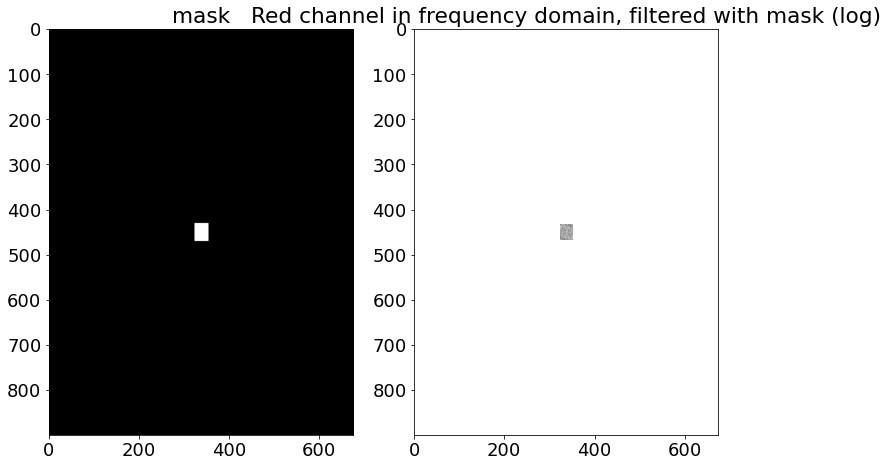

In [34]:
# apply gain to binary message
bin_encoded, bin_encoded_raw  = generateMessage(string, gain, Colorspace(colorspace))
# bin_encoded =  text_to_bits_int(string, gain, Colorspace(colorspace))
print("bin_encoded:", bin_encoded[-1][:20])

def create_FFTmask(columns, rows, message, optcut = None):
    # calculate minimum part to be cut and add another 3% because of rounding errors and for "safety"
    cut = np.sqrt(2*len(message)/(rows*columns))*1.03
    if cut > max_cut:
        raise Exception("The message is too large. Major distortions are to be expected.")
    elif not optcut:
        cut = max_cut

    #cut off high frequencies from R channel
    mask = np.full((rows, columns), False)
    row_start = round(rows/2*(1-cut))
    row_stop = round(rows/2*(1+cut))
    col_start = round(columns/2*(1-cut))
    col_stop = round(columns/2*(1+cut))
    mask[row_start:row_stop, col_start:col_stop] = True  # rectangular

    # x-length of the mask
    x_len_mask = col_stop - col_start 
    # y-length of the mask
    y_len_mask = row_stop - row_start 

    print("cut: ", cut)
    print("message length:", len(message))
    print("confirm:", x_len_mask*y_len_mask/2)

    return mask, cut

# create mask from largest portion of message -> last channel with the header
cover_fft_mask, cut = create_FFTmask(*(image.size), bin_encoded[-1], optcut)
# cover_fft_mask, cut = create_FFTmask(*(image.size), bin_encoded, False)
print(cover_fft_mask[:20])
print(cover_fft_mask.shape)
print(channel[-1].size)

cover_fft_masked = np.abs(np.fft.fft2(channel[-1]))*cover_fft_mask
plt.figure()
plt.subplot(121)
plt.imshow(cover_fft_mask, cmap="gray")
plt.title("mask")
plt.subplot(122)
plt.imshow(10*np.log10(cover_fft_masked), cmap="gray")
plt.title("Red channel in frequency domain, filtered with mask (log)")

### embed the message into the absolute FT

length binary encoded message:  3


C:\Users\maxik\AppData\Local\Temp/ipykernel_15448/3498517133.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(Image.fromarray(20*np.log10(fft_abs)))


cover_masked length:  3


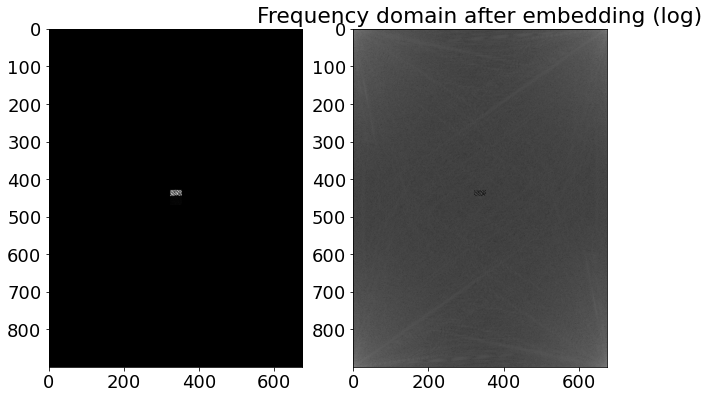

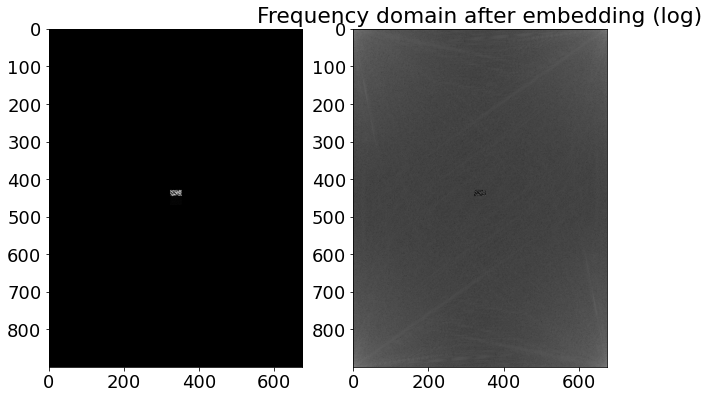

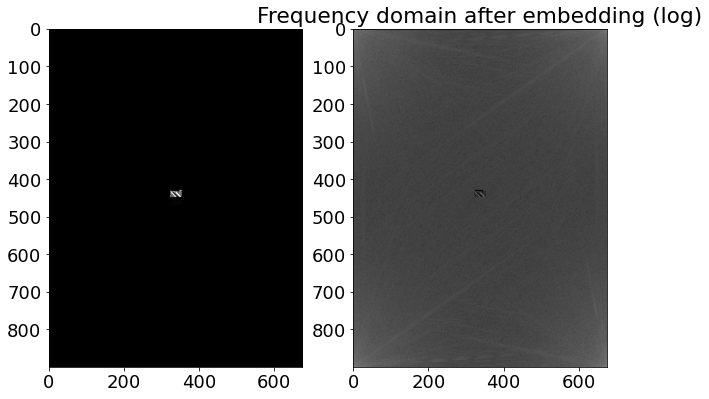

Image saved! : ImageSources\Steganograms\remerged_sharp.png


In [35]:
def embedBin2FFT(cover_channel, mask, message_digital):
    fft = np.fft.fft2(cover_channel)
    fft_abs = np.abs(fft)
    # cache message length
    message_len = len(message_digital)


    masked_fft = fft_abs[mask]

    for ii in range(message_len):
        masked_fft[ii] = message_digital[ii]
    fft_abs[mask] = masked_fft

    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(fft_abs*mask, cmap="gray")

    # plot absolute after embedding information
    plt.subplot(122)
    plt.imshow(Image.fromarray(20*np.log10(fft_abs)))
    plt.title("Frequency domain after embedding (log)")

    #IFFT on single channel. Take filtered absolute and inverse with original phase, imaginary part should be negligable
    cover_masked = np.fft.ifft2(np.multiply(fft_abs, np.exp(np.multiply(1j, np.angle(fft))))).real
    return cover_masked


print("length binary encoded message: ", len(bin_encoded))
# print("binary encoded message: ", bin_encoded)


# embed the message into their respective channels by using the mask from the 'header channel'
cover_masked = []
for ix, bin_encoded_channel in enumerate(bin_encoded):
    cover_masked.append(embedBin2FFT(channel[ix+3-len(bin_encoded)], cover_fft_mask, bin_encoded_channel))

print("cover_masked length: ", len(cover_masked))

# normalize output
cover_masked_clip = []
for channel_masked in cover_masked:
    cover_masked_clip.append(np.clip(channel_masked, 0,255).astype("uint8"))
# cover_r_masked_norm = convert(cover_r_masked, 0,255, np.uint8)

# merge layers
if len(bin_encoded) == 2:
    stego =  np.stack((channel[0], cover_masked_clip[0], cover_masked_clip[1]), axis=2).astype('uint8')
elif len(bin_encoded) == 3:
    stego =  np.stack((cover_masked_clip[0], cover_masked_clip[1], cover_masked_clip[2]), axis=2).astype('uint8')

# create steganogram and convert back to RGB again
stego_img = Image.fromarray(stego, Colorspace(colorspace).name).convert(Colorspace.RGB.name)

# save stego image in defined format, default: png
im = stego_img.save("ImageSources\\Steganograms\\remerged_sharp." + ImageType(image_type).name)     #save image as png

plt.show()
print("Image saved! : " + "ImageSources\\Steganograms\\remerged_sharp." + ImageType(image_type).name)

### Plot histograms

<Figure size 864x576 with 0 Axes>

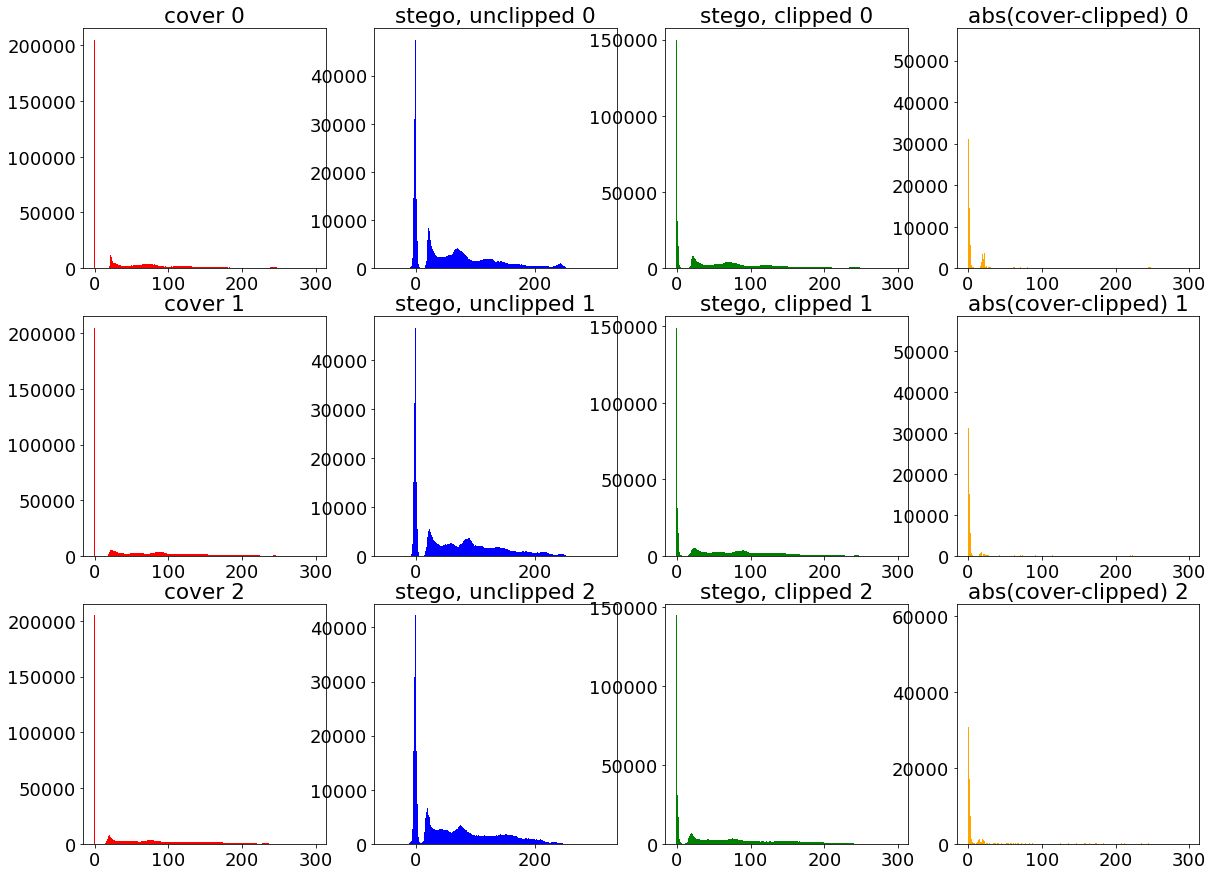

In [36]:
# h0 = []
# e0 = []
# plt.figure(figsize=(20,5))
# for ix, ch in enumerate(channel):
#     hist0, edges0 = np.histogram(np.array(ch), bins=range(300))
#     plt.subplot(14*10 + ix + 1)
#     plt.bar(edges0[:-1], hist0, width = 1, color='red')
#     plt.xlim(-10, max(edges0))
#     plt.title(f"cover {ix}")
#     h0.append(hist0)
#     e0.append(edges0)

# plt.figure(figsize=(20,5))
# for ix, ch in enumerate(cover_masked):
#     hist1, edges1 = np.histogram(ch, bins=range(-50,320))
#     plt.subplot(14*10 + ix + 1)
#     plt.bar(edges1[:-1], hist1, width = 1, color='blue')
#     plt.xlim(min(edges1), max(edges1))
#     plt.title(f"stego, unclipped {ix}")
# print(np.min(cover_masked))
# print(np.max(cover_masked))

# h2 = []
# e2 = []
# plt.figure(figsize=(20,5))
# for ix, ch in enumerate(cover_masked_clip):
#     hist2, edges2 = np.histogram(ch, bins=range(300))
#     plt.subplot(14*10 + ix + 1)
#     plt.bar(edges2[:-1], hist2, width = 1, color='green')
#     plt.xlim(-10, max(edges2))
#     plt.title(f"stego, clipped {ix}")
#     h2.append(hist2)
#     e2.append(edges2)

# plt.figure(figsize=(20,5))
# for ix, ch in enumerate(h2):
#     hist3 = np.abs(h0[ix+3-len(h2)] - ch)
#     plt.subplot(14*10 + ix + 1)
#     plt.bar(e2[ix][:-1], hist3, width = 1, color='orange')
#     plt.xlim(-10, max(e2[ix]))
#     plt.ylim(0,max(h0[ix+3-len(h2)]))
#     plt.title(f"abs(cover-clipped) {ix}")

# plt.show()

plt.figure()
fig, axs = plt.subplots(3, 4, figsize=(20,15))
for ix in range(len(channel)):
    hist0, edges0 = np.histogram(np.array(channel[ix]), bins=range(300))
    axs[ix, 0].bar(edges0[:-1], hist0, width = 1, color='red')
    # axs[ix, 0].xlim(-10, max(edges0))
    axs[ix, 0].set_title(f"cover {ix}")
    if (len(cover_masked) == 2) and (ix == 0):
        axs[ix, 1].plot()
        axs[ix, 2].plot()
        axs[ix, 3].plot()
        continue
    hist1, edges1 = np.histogram(cover_masked[ix-3+len(cover_masked)], bins=range(-50,320))
    axs[ix, 1].bar(edges1[:-1], hist1, width = 1, color='blue')
    axs[ix, 1].set_title(f"stego, unclipped {ix}")
    hist2, edges2 = np.histogram(cover_masked_clip[ix-3+len(cover_masked_clip)], bins=range(300))
    axs[ix, 2].bar(edges2[:-1], hist2, width = 1, color='green')
    axs[ix, 2].set_title(f"stego, clipped {ix}")
    hist3 = np.abs(hist0 - hist2)
    axs[ix, 3].bar(edges2[:-1], hist3, width = 1, color='orange')
    axs[ix, 3].set_title(f"abs(cover-clipped) {ix}")


plt.show()

### Some more plots

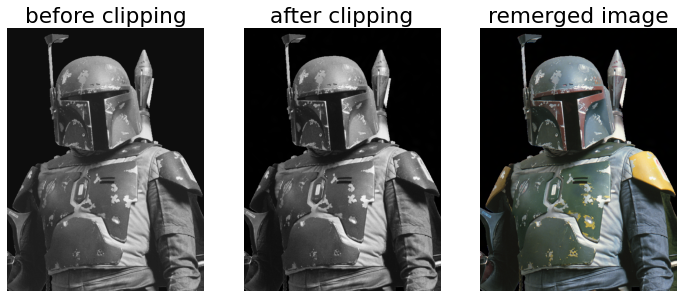

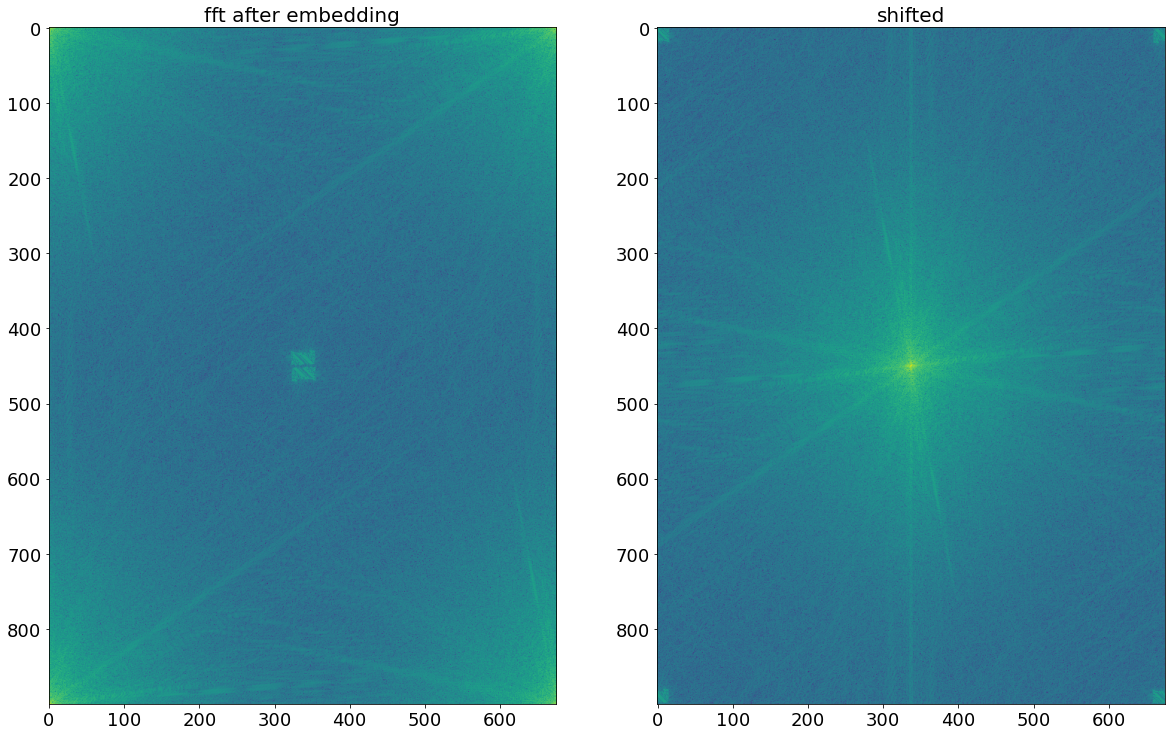

Text(0.5, 0.92, 'surface plot shifted')

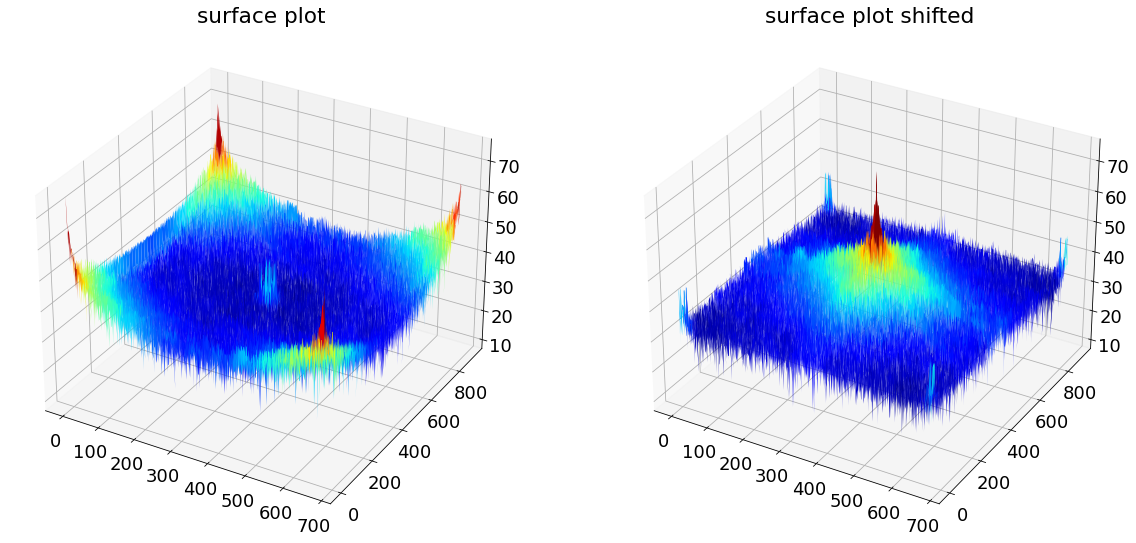

In [37]:
plt.figure()
plt.subplot(131)
plt.axis('off')
plt.imshow(cover_masked[-1], cmap="gray")
plt.title("before clipping")
plt.subplot(132)
plt.axis('off')
plt.imshow(cover_masked_clip[-1], cmap="gray")
plt.title("after clipping")
plt.subplot(133)
plt.axis('off')
plt.imshow(stego_img) #Show picture with embeddes secret message
plt.title("remerged image")



sanity_check = 10*np.log10(np.abs(np.fft.fft2(cover_masked_clip[-1])))
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(sanity_check)
plt.title("fft after embedding", fontsize=20)
sanity_check_shift = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft2(cover_masked_clip[-1]))))
plt.subplot(122)
plt.imshow(sanity_check_shift)
plt.title("shifted", fontsize=20)

plt.show()


fig = plt.figure(figsize=(20,20))
# plt.subplot(121)
y_len = len(sanity_check)
x_len = len(sanity_check[0,:])
c = np.meshgrid(np.arange(0,x_len), np.arange(0,y_len))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_surface(c[0], c[1], sanity_check, cmap='jet')
plt.title("surface plot")
# plt.subplot(122)

ax = fig.add_subplot(1,2,2,projection='3d')
ax.plot_surface(c[0], c[1], sanity_check_shift, cmap='jet')
plt.title("surface plot shifted")

<br>
<br>
<br>

# Decoding
----

### Calculate mask from cut variable

Text(0.5, 1.0, 'calculated fft mask')

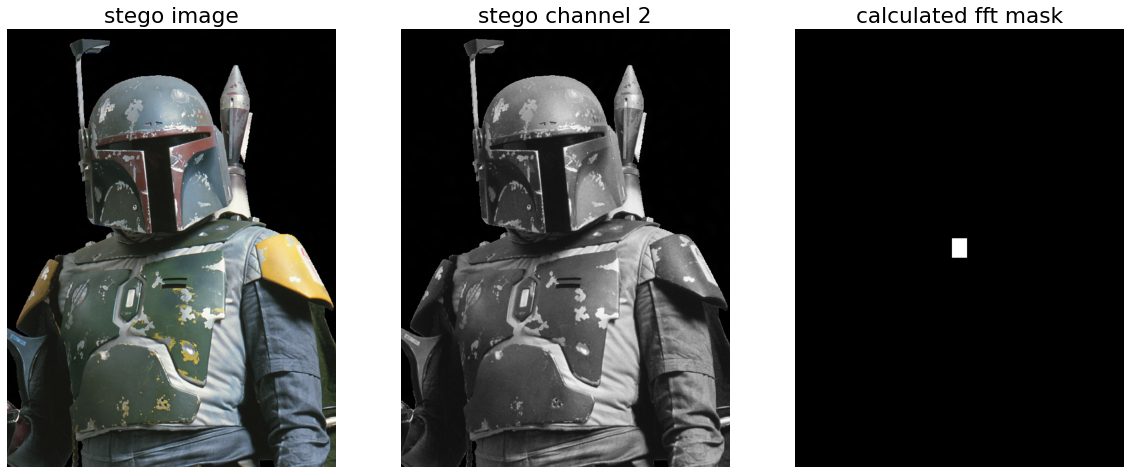

In [38]:
# load and plot image
stego_img = Image.open("ImageSources\\Steganograms\\remerged_sharp." + ImageType(image_type).name).convert(Colorspace(colorspace).name)
# stego_img = Image.open("ImageSources\\Steganograms\\remerged_sharp.png").convert("YCbCr")

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.axis("off")
plt.imshow(stego_img.convert(Colorspace.RGB.name))
plt.title("stego image")

steg_channel = stego_img.split() #split image into its RGB channels

plt.subplot(132)
plt.axis("off")
plt.imshow(steg_channel[-1], cmap="gray")
plt.title("stego channel 2", )

# calculate mask
def calculate_FFTmask(columns, rows, cut = None):
    if not cut:
        cut = max_cut
    stego_fft_mask = np.full((rows, columns), False)
    row_start = round(rows/2*(1-cut))
    row_stop = round(rows/2*(1+cut))
    col_start = round(columns/2*(1-cut))
    col_stop = round(columns/2*(1+cut))
    stego_fft_mask[row_start:row_stop, col_start:col_stop] = True  # rectangular

    return stego_fft_mask

stego_fft_mask = calculate_FFTmask(*(stego_img.size), cut)
# stego_fft_mask = calculate_FFTmask(*(stego_img.size))

plt.subplot(133)
plt.axis("off")
plt.imshow(stego_fft_mask, cmap="gray")
plt.title("calculated fft mask")

raw_message[-1][:30]: 
 [ 2942  3339  8048  2333  3456  3058  7019  5801  1482  2635  9185  8490
  2997  3906  4851  4702  5064  2422  7117  5082  9704  2803  1882  3626
 37834 31202 53463  4784 48814 39428]
threshold max/2 [26867.0, 26808.0, 27399.0]
parsed message length:  [474, 347, 475]
3
3
0 woohoo, the binary messages align!
1 hmmm, it seems the constellation is not quite there yet...
2 hmmm, it seems the constellation is not quite there yet...
bin_decoded:
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eibmod tempor invidunt et labona aliauyam🖐🤚🖖👋🖐🤚𞖖𗑋🖐🤚🖖👋
correct text:
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam🖐🤚🖖👋🖐🤚🖖👋🖐🤚🖖👋


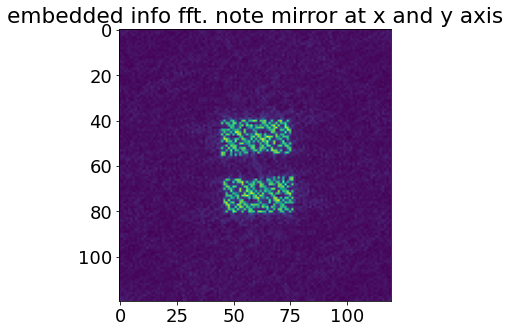

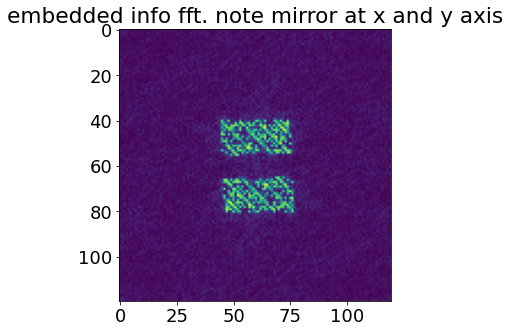

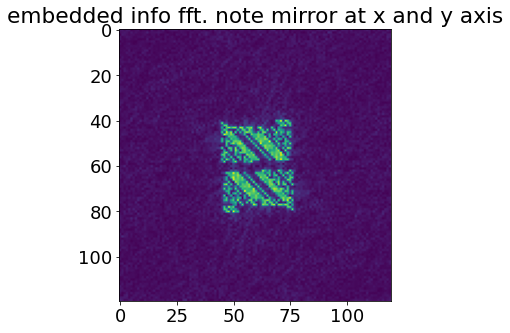

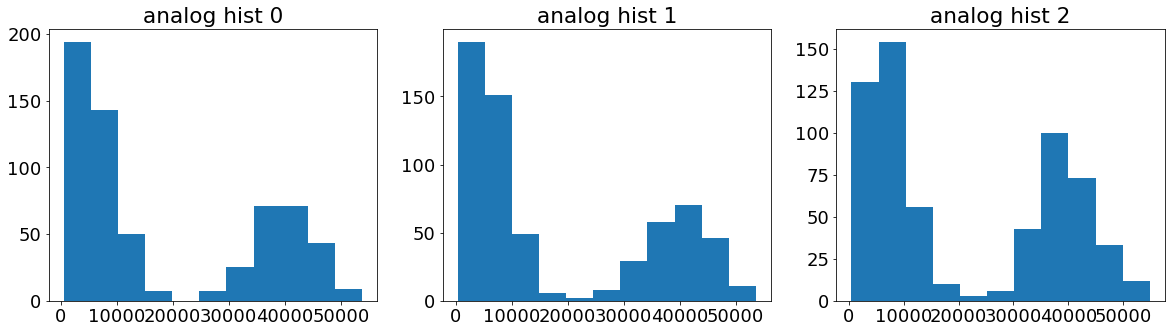

In [39]:
def get_message(stego_channel, mask):
    # transform R channel into frequency domain
    stego_fft =np.fft.fft2(stego_channel)
    stego_fft_abs = np.abs(stego_fft)

    size = stego_fft.shape
    pixel = 60
    plt.figure(figsize=(5,5))
    plt.imshow(stego_fft_abs[size[0]//2-pixel:size[0]//2+pixel, size[1]//2-pixel:size[1]//2+pixel])
    plt.title("embedded info fft. note mirror at x and y axis")
    
    # calculate message length from mask -> predicted message length > true message length!
    message_length = int(np.count_nonzero(mask == True)//2)
    # print("predicted message length: ", message_length)

    # create message buffer
    message=np.zeros(message_length, dtype='uint32')

    stego_fft_masked = stego_fft_abs[mask]
    for ii in range(message_length):
        message[ii] = stego_fft_masked[ii]

    return message

# calculate threshold
def threshold_otsu(array):
    print(np.max(array))
    [hist, _] = np.histogram(array, bins=np.max(array))
    # Normalization so we have probabilities-like values (sum=1)
    hist = 1.0*hist/np.sum(hist)

    val_max = -999
    thr = -1
    for t in range(1,np.max(array)):
        # create both classes
        q1 = np.sum(hist[:t])
        q2 = np.sum(hist[t:])
        # calculate mean
        m1 = np.sum(np.array([i for i in range(t)])*hist[:t])/q1
        m2 = np.sum(np.array([i for i in range(t,np.max(array))])*hist[t:])/q2
        # calculate variance
        val = q1*(1-q1)*np.power(m1-m2,2)
        if val_max < val:
            val_max = val
            thr = t
    return thr

# copy analog values into buffer
raw_message = []
for steg_ch in steg_channel:
    raw_message.append(get_message(steg_ch, stego_fft_mask))

print("raw_message[-1][:30]: \n", raw_message[-1][:30])

# plot histogram
plt.figure(figsize=(20,5))
for ix, message in enumerate(raw_message):
    plt.subplot(13*10 + 1 + ix)
    hist = np.hstack(message)
    plt.hist(hist, bins="auto")
    plt.title("analog hist " + str(ix))

# convert message values to binary
# try decoding all 3 channels first, then decode in YCbCr colorspace
try:
    # calculate threshold the fast and easy way
    threshold = [np.max(m)/2 for m in raw_message]
    print("threshold max/2", threshold)
    string_decoded, stego_binary = parseMessage(raw_message, threshold)
except IndexError:
    print("Parsing all 3 channels failed, retrying with only 2...")
    threshold = [np.max(m)/2 for m in raw_message[1:]]
    print("threshold max/2", threshold)
    string_decoded, stego_binary = parseMessage(raw_message[1:], threshold)


print(len(stego_binary))
print(len(bin_encoded_raw))
for ix, layer in enumerate(bin_encoded_raw):
    if stego_binary[ix] == layer:
        print(f"{ix} woohoo, the binary messages align!")
    else:
        print(f"{ix} hmmm, it seems the constellation is not quite there yet...")

# binary = message2bin(raw_message, threshold)
# print("binary", binary[:30])  # first 2 bytes are length of the embedded message

# convert binary to utf-8
# Text, message_len_decoded, colorspace_decoded = text_from_bits_int(binary)
# print("parsed message length", message_len_decoded)
# print("parsed colorspace", Colorspace(colorspace_decoded).name)


print("bin_decoded:")
print(string_decoded)
print("correct text:")
print(string)

<br>
<br>
<br>

# Automated encoding and decoding with functions from FFT_stego.py
----

Now implement a gain finder algorithm

In [1]:
from FFT_stego import *
# from FFT_stego import reset_settings

cover_img_path ="ImageSources\\jfif\\obi-wan_kenobi.jfif"
# cover_img_path ="ImageSources\\tif\\lena_color_512.tif"

# stego_img_path = stego_path_generator(cover_img_path, "png")
# print(stego_img_path)

# input string
string=\
"""\
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam🖐🤚🖖👋🖐🤚🖖👋🖐🤚🖖👋\
"""
# """
# It's about drive, it's about power💪🧱▶🟥🎶🎧
# We stay hungry, we devour
# Put in the work, put in the hours and take what's ours (ahoo)
# Black and Samoan in my veins
# My culture bangin' with Strange
# I change the game, so what's my motherfuckin' name (Rock)
# (What they gonna get though?)
# Desecration, defamation, if you wanna bring it to the masses
# Face to face, now we escalatin', when I have to put boots to asses
# Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
# So bring drama to the King Brahma (then what?) 
# Comin' at you with extreme mana
# """


set_settings(optcut_=True, recursive_count_=20,colorspace_=Colorspace.RGB, image_type_=ImageType.png)
# set_img_path(cover_img_path, stego_path_generator(cover_img_path, ImageType.tif))
# set_message(string)

# cut = steg_encode([10000,10001,10002])
# cut = steg_encode(10000)

# load_settings()

# %load_ext snakeviz
# %snakeviz cut, gain =steg_encode_simple(cover_img_path, string, optcut=True, recursive_cnt=10)
cut, gain =steg_encode_simple(cover_img_path, string)

# print("cut value:", cut)
print("Final gain: ", gain)
Text,_ = steg_decode(cut)
print("parsed text:", Text)
# print("gain:", gain) 

USER variable(s) set!
No gain found, almost there:  [10000, 10000, 10000]
No gain found, almost there:  [20000, 20000, 20000]
Gain found!:  [80000, 80000, 80000]
found best gain after 16 tries.
embeding of secret message complete: d:\GitCloned\Projektarbeit\Steganosaurus\ImageSources\Steganograms\obi-wan_kenobi_steg.png
Final gain:  [43868, 44119, 44267]
parsed text: Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam🖐🤚🖖👋🖐🤚🖖👋🖐🤚🖖👋


Works with the following image file formats:
*   png
*   bmp
*   tiff
*   webp (not recommended)